In [1]:
!pip install trimesh
import os
import glob
import trimesh
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 688.5/688.5 kB 9.1 MB/s eta 0:00:00


In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(f'GPUs Available: {len(physical_devices)}')
if physical_devices: tf.config.experimental.set_memory_growth(physical_devices[0], True)

GPUs Available: 1


# Set parameters

In [3]:
N_POINTS= 17
N_CLASSES = 1
SAMPLES_PER_MESH = 50
BATCH_SIZE = 16

# Dataset download

In [4]:
DATA_DIR = tf.keras.utils.get_file(
    "modelnet.zip","http://modelnet.cs.princeton.edu/ModelNet40.zip"
    "",
    extract=True,
)
DATA_DIR = os.path.join(os.path.dirname(DATA_DIR), "ModelNet40")

2039180837/2039180837 [==============================] - 143s 0us/step


# Parse dataset
* **Data Parser:** Each mesh is loaded ans sampled into a point cloud and is returned as a numpy array

In [5]:
def objectPerspective(points, centroid, angle, n=100):
    if not (-np.pi < angle < np.pi):
        raise ValueError('Angle must be between -pi and pi')

    complexes = np.empty(len(points), dtype=np.complex64)
    complexes.real = points[:,0] - centroid[0]
    complexes.imag = points[:,1] - centroid[1]
    subset = points[np.angle(complexes) <= angle]

    if subset.shape[0] > 0:
        return subset[np.random.choice(subset.shape[0], n, replace=(subset.shape[0] < n)), :]
    else:
        return points[np.random.choice(points.shape[0], n, replace=(points.shape[0] < n)), :]

def meshMultisample(mesh, num_points, n):
    samples = []
    centroid = mesh.centroid
    for i in range(n):
        samples.append(objectPerspective(mesh.sample(2048), centroid, np.random.uniform(-np.pi/2, np.pi), num_points))

    return samples

def nRandomNoConeSamples(n, mode, num_points):
    """ mode = [train|test]"""
    points = []
    labels = []
    files = list(set(glob.glob(os.path.join(DATA_DIR, f"[!README]*/{mode}/*"))) - set(glob.glob(os.path.join(DATA_DIR, f"cone/{mode}/*"))))

    for i in range(n):
        # gather all files
        f = np.random.choice(files, replace=False)

        mesh = trimesh.load(f)
        centroid = mesh.centroid
        points.append(objectPerspective(mesh.sample(2048), centroid, np.random.uniform(-np.pi/2, np.pi), num_points))
        labels.append(0)

    return points, labels

def parse_dataset(num_points=N_POINTS, samples=SAMPLES_PER_MESH):
    train_points = []
    train_labels = []
    test_points = []
    test_labels = []
    # store cone label name with value so we can retrieve later
    class_map = {
        0: 'no-cone',
        1: 'cone'
    }

    cone_folder = os.path.join(DATA_DIR, 'cone/')

    # gather all files
    train_files = glob.glob(os.path.join(cone_folder, 'train/*'))
    test_files = glob.glob(os.path.join(cone_folder, 'test/*'))


    print('(1/4)\t\tprocessing class cone train\t\t', end='')
    for f in train_files:
        train_points.extend(meshMultisample(trimesh.load(f), num_points, samples))
        train_labels += [1] * samples

    cone_train_cardinality = len(train_labels)
    print(f'{cone_train_cardinality} cones')

    print('(2/4)\t\tprocessing class cone test\t\t', end='')
    for f in test_files:
        test_points.extend(meshMultisample(trimesh.load(f), num_points, 1))
        test_labels.append(1)

    cone_test_cardinality = len(test_labels)
    print(f'{cone_test_cardinality} cones')

    print('(3/4)\t\tprocessing class no-cone train\t\t', end='')
    points, labels = nRandomNoConeSamples(cone_train_cardinality, mode='train', num_points=num_points)
    train_points.extend(points)
    train_labels.extend(labels)

    print(f'{len(labels)} no-cones')
    print('(4/4)\t\tprocessing class no-cone test\t\t', end='')
    points, labels = nRandomNoConeSamples(cone_test_cardinality, mode='test', num_points=num_points)
    test_points.extend(points)
    test_labels.extend(labels)

    print(f'{len(labels)} no-cones')
    return (
        np.array(train_points),
        np.array(train_labels),
        np.array(test_points),
        np.array(test_labels),
        class_map
    )


In [6]:
train_points, train_labels, test_points, test_labels, CLASS_MAP = parse_dataset(N_POINTS)

(1/4)		processing class cone train		8350 cones
(2/4)		processing class cone test		20 cones
(3/4)		processing class no-cone train		8350 no-cones
(4/4)		processing class no-cone test		20 no-cones


In [7]:
print(len(train_labels))
print(f'training: The number of cone and no-cone samples is{"" if sum(train_labels) == len(train_labels)/2 else " not"} equal')
print(len(test_labels))
print(f'testing: The number of cone and no-cone samples is{"" if sum(test_labels) == len(test_labels)/2 else " not"} equal')

16700
training: The number of cone and no-cone samples is equal
40
testing: The number of cone and no-cone samples is equal


# Data augmentation

In [8]:
def augment(points, label):
  # jitter points
  points += tf.random.uniform(points.shape, -0.05, 0.05, dtype=tf.float64)
  # shuffle points
  points = tf.random.shuffle(points)
  return points, label

train_dataset = tf.data.Dataset.from_tensor_slices((train_points, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_points, test_labels))

train_dataset = train_dataset.shuffle(len(train_points)).map(augment).batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)

# Model Building

In [9]:
def conv_bn(x, filters):
  x = layers.Conv1D(filters, kernel_size=1, padding='valid')(x)
  x = layers.BatchNormalization(momentum=0.0)(x)
  return layers.Activation('relu')(x)

def dense_bn(x, filters):
  x = layers.Dense(filters)(x)
  x = layers.BatchNormalization(momentum=0.0)(x)
  return layers.Activation('relu')(x)

In [10]:
class OrthogonalRegularizer(keras.regularizers.Regularizer):
  def __init__(self, num_features, l2reg=0.001):
    self.num_features = num_features
    self.l2reg = l2reg
    self.eye = tf.eye(num_features)

  def __call__(self, x):
    x = tf.reshape(x, (-1, self.num_features, self.num_features))
    xxt = tf.tensordot(x, x, axes=(2,2))
    xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
    return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))

## T-net layers

In [11]:
def tnet(inputs, num_features):
  # initialize bias as the identity matrix
  bias = keras.initializers.Constant(np.eye(num_features).flatten())
  reg = OrthogonalRegularizer(num_features)

  x = conv_bn(inputs, 32)
  x = conv_bn(x, 64)
  x = conv_bn(x, 512)
  x = layers.GlobalMaxPooling1D()(x)
  x = dense_bn(x, 256)
  x = dense_bn(x, 128)
  x = layers.Dense(
      num_features * num_features,
      kernel_initializer='zeros',
      bias_initializer=bias,
      activity_regularizer=reg
  )(x)
  feat_T = layers.Reshape((num_features, num_features))(x)
  # Apply affine transformation to input features
  return layers.Dot(axes=(2, 1))([inputs, feat_T])

## CNN

In [12]:
inputs = keras.Input(shape=(N_POINTS, 3))

x = tnet(inputs, 3)
x = conv_bn(x, 32)
x = conv_bn(x, 32)
x = tnet(x, 32)
x = conv_bn(x, 32)
x = conv_bn(x, 64)
x = conv_bn(x, 512)
x = layers.GlobalMaxPooling1D()(x)
x = dense_bn(x, 256)
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 128)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(N_CLASSES, activation='sigmoid')(x)

model = keras.Model(inputs=inputs, outputs=outputs, name='pointnet')
model.summary()

Model: "pointnet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 17, 3)]              0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 17, 32)               128       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 17, 32)               128       ['conv1d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 17, 32)               0         ['batch_normalization[0

## Compile and train

In [13]:
model.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

model.fit(train_dataset, epochs=15, validation_data=test_dataset)

Epoch 1/15
1044/1044 [==============================] - 58s 29ms/step - loss: 1.2977 - accuracy: 0.5657 - val_loss: 3.1876 - val_accuracy: 0.6250
Epoch 2/15
1044/1044 [==============================] - 30s 28ms/step - loss: 1.2271 - accuracy: 0.6049 - val_loss: 664964.1250 - val_accuracy: 0.5500
Epoch 3/15
1044/1044 [==============================] - 31s 29ms/step - loss: 1.1773 - accuracy: 0.6333 - val_loss: 585662747115520.0000 - val_accuracy: 0.6500
Epoch 4/15
1044/1044 [==============================] - 31s 29ms/step - loss: 1.1644 - accuracy: 0.6465 - val_loss: 115.6964 - val_accuracy: 0.5500
Epoch 5/15
1044/1044 [==============================] - 30s 29ms/step - loss: 1.1441 - accuracy: 0.6529 - val_loss: 738822455296.0000 - val_accuracy: 0.5250
Epoch 6/15
1044/1044 [==============================] - 30s 28ms/step - loss: 1.1312 - accuracy: 0.6617 - val_loss: 250140496.0000 - val_accuracy: 0.6000
Epoch 7/15
1044/1044 [==============================] - 29s 28ms/step - loss: 1.1204

# Results

1/1 [==============================] - 0s 37ms/step


IndexError: ignored

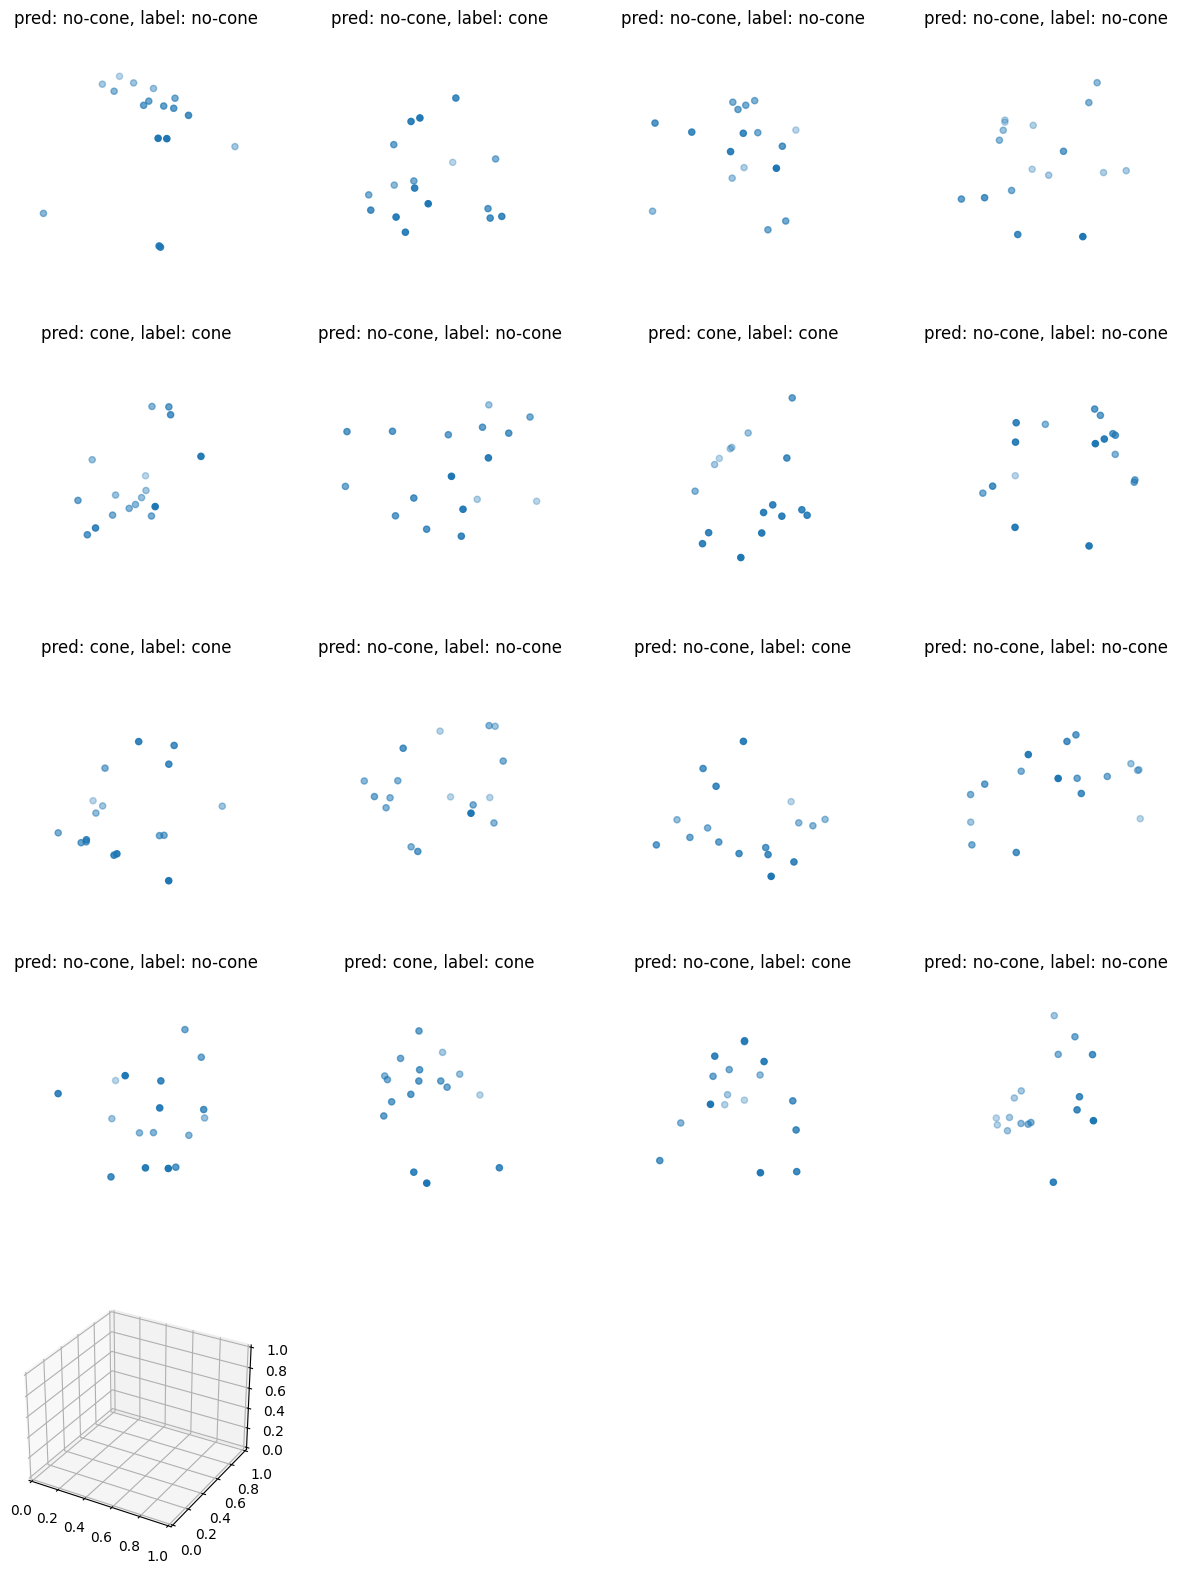

In [21]:
N_TESTS = 32
THRESHOLD = .5

data = test_dataset.take(1)

points, labels = list(data)[0]

points = points[:N_TESTS, ...]
labels = labels[:N_TESTS, ...]

# run test data through model
preds = model.predict(points)
preds = [int(pred > THRESHOLD) for pred in preds]
points = points.numpy()

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 4*np.ceil(N_TESTS/4)))
for i in range(N_TESTS):
  ax = fig.add_subplot(int(np.ceil(N_TESTS/4)), 4, i + 1, projection='3d')
  ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
  ax.set_title(
      f'pred: {CLASS_MAP[preds[i]]}, label: {CLASS_MAP[labels.numpy()[i]]}'
  )
  ax.set_axis_off()
plt.show()

In [16]:
results = model.evaluate(train_dataset)
print(results)

1044/1044 [==============================] - 17s 16ms/step - loss: inf - accuracy: 0.7847
[inf, 0.7847305536270142]


In [18]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [19]:
model.save_weights('/content/gdrive/MyDrive/Colab_PN/pn_weights_17.h5')

In [20]:
export_dir = '/content/gdrive/MyDrive/Colab_PN/saved_model_17'
tf.saved_model.save(model, export_dir=export_dir)